# Gaussian Mixture Models

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')

- *k*-means 클러스터링 모델은 간단하고 상대적으로 이해하기 쉽지만 비모수 특성과 클러스터에 할당하기 위해 클러스터 중심으로부터의 단순한 유클리디언 거리를 사용하면 많은 실제 상황에서 성능이 저하

- 단순한 *k*-means 클러스터링을 넘어서는 가우스 혼합 모델 (GMM)

## 1. Motivating GMM: Weaknesses of k-Means

- 두 중간 군집 사이에 아주 약간 겹치는 것처럼 보이므로 군집 할당에 대한 불확실성(불확실성을 추정하기 위해 부트 스트랩)
- 유클리디언 거리를 나타내는 원이 아니 타원(특정군집의 분포를 표현)으로 군집을 구분할 수 있음

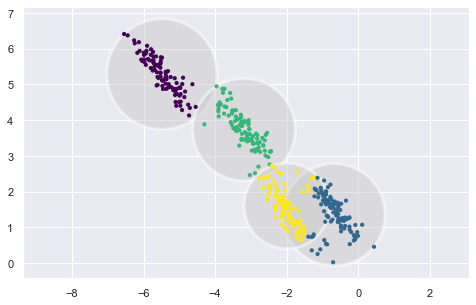

In [2]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    plt.figure(figsize=(8, 5))
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', zorder=2)
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
kmeans = KMeans(n_clusters=4, random_state=0)
                
plot_kmeans(kmeans, X_stretched)

- 눈으로 볼 때 이러한 변환 된 클러스터는 원형이 아니므로 원형 클러스터는 적합하지 않음에도 불구하고 *k*-평균은 데이터를 4 개의 원형 클러스터에 강제로 할당하게 되어 원(군집)이 겹치는 부분(굽집 할당의 불확실성)이 발생
   * 인스턴스의 크기가 적은 경우에는 심각해짐
- 원형보다는 타원형(가우시안분포 형태)으로 군집을 구성하는 것이 GMM

Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

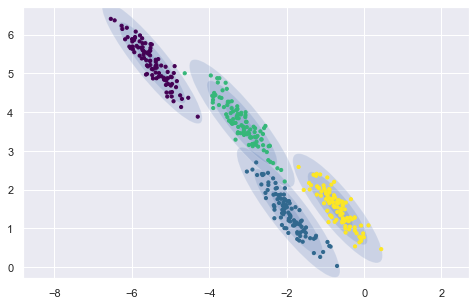

In [3]:
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
def plot_gmm(gmm, X, label=True, ax=None):
    plt.figure(figsize=(8, 5))
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=10, zorder=2)
    ax.axis('equal')    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

<font color = 'red'> This makes clear that GMM addresses the two main practical issues with *k*-means encountered before.

## 2. Generalizing E–M: Gaussian Mixture Models

- 가우스 혼합 모델(GMM)은 입력 데이터 세트를 가장 잘 모델링하는 다차원 가우스 확률 분포의 혼합을 최적으로 탐색
- *k*-평균과 동일한 방식인 EM을 GMM에 적용하여 군집을 결정

- GMM은 확률적모형에서 데이터를 생성하는 Generative Model
- 군집 할당에 대한 확률은 Scikit-Learn의 `predict_proba` 함수를 사용하여 특정 인스턴스가 특정 군집에 속할 확률을 생성
   * `[n_samples, n_clusters]` 

In [4]:
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
probs = gmm.predict_proba(X)
print(probs.round(3))
probs.max(1)[:5]

[[0.537 0.463 0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 ...
 [0.    0.    1.    0.   ]
 [0.563 0.    0.    0.437]
 [0.    0.    1.    0.   ]]


array([0.53671156, 1.        , 1.        , 0.99991836, 1.        ])

- 인스턴스가 군집에 속할 확률을 구한 후 size(= 50 * probs.max(1) ** 2)로 변환하여 시각화
    * 군집이 겹치는 부분의 확률이 낮아 불확실성이 높게 되어 size가 작게 표현

### Choosing the covariance type
- GMM의 파라미터인 covariance_type 옵션이 각각에서 다르게 설정 가능
     * 기본값은 covariance_type = "diag"으로 각 차원을 따라 클러스터의 크기를 독립적으로 설정할 수 있으며 결과 타원은 축과 정렬되도록 제한됩니다. 
     * covariance_type = "spherical"으로, 모든 차원이 동일하도록 클러스터의 모양을 제한하여 클러스터링은 완전히 동일하지는 않지만 k- 평균과 유사한 특성
     * 더 복잡하고 계산 비용이 많이 드는 모델 (특히 차원 수가 증가함에 따라)은 covariance_type = "full"을 사용하여 각 클러스터를 임의의 방향을 가진 타원으로 모델링

## 3. GMM as *Density Estimation*
- GMM은 종종 클러스터링 알고리즘으로 분류되지만 기본적으로 *밀도 추정*을 위한 알고리즘
    * 일부 데이터에 대한 GMM 피팅의 결과(pdf로 fitting)는 기술적으로 클러스터링 모델이 아니라 데이터 분포를 설명하는 생성적 확률 모델(generative probabilistic model)

<Figure size 576x360 with 0 Axes>

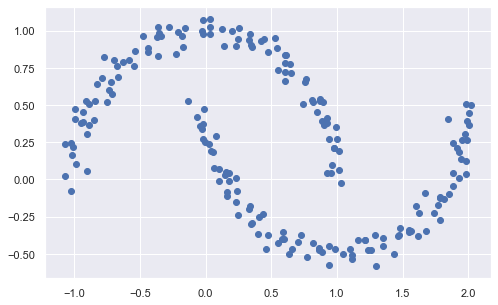

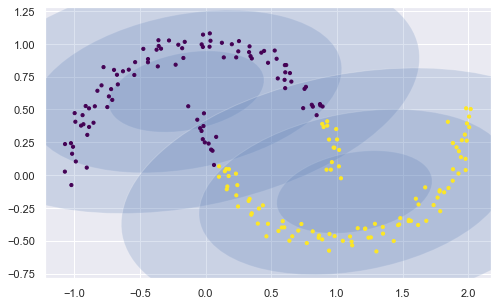

In [5]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.figure(figsize=(8, 5))
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);plt.show()
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

<font color='red'> 군집의 개수를 2개로 하여 clustering하게 되면 별 의미가 없음

<font color='red'> 군집의 개수를 16개를 하여 GMM을 적용하게 되면 입력변수와 거의 유사한 분포를 확인 할 수 있음 (군집의 label은 의미가 없음)

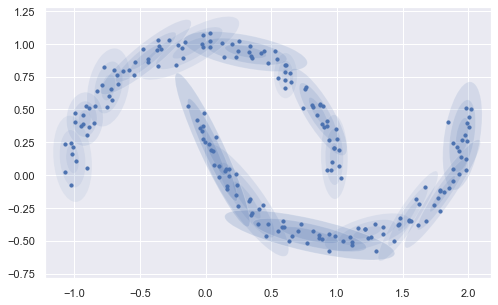

In [6]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

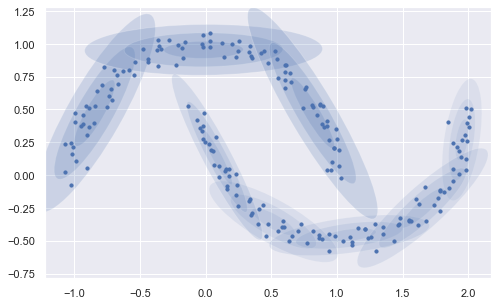

In [8]:
gmm8 = GaussianMixture(n_components=8, covariance_type='full', random_state=0)
plot_gmm(gmm8, Xmoon, label=False)

#### <font color='green'> GMM(군집 16개)은 Custering이 아니라 입력 데이터의 전체 *분포*를 모델링하는 데 사용
- 즉 분포의 생성 모델로 GMM이 입력과 유사하게 분포 된 새로운 임의 데이터를 생성 할 수 있게 된다.

### 군집의 개수 결정은 어떤 지표로 결정하나?

- GMM이 생성 모델이라는 사실은 주어진 데이터 세트에 대한 최적의 구성 요소 수를 결정하는 자연스러운 방법을 제공하게 됨
- 생성 모델은 본질적으로 데이터 세트에 대한 확률 분포이므로 교차 검증을 사용하여 과적합을 방지하여 특정 모델의 가정을 전제로 한 데이터의 *가능성(likelihood)*을 간단히 평가할 수 있음
- 과적합을 수정하는 또 다른 방법은 Akaike information criterion (AIC), Bayesian_information_criterion)을 사용
  * Scikit-Learn은 두 가지를 모두 계산
- Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

### BIC = log(m)p − 2 log(L^)
### AIC = 2p − 2 log(L)
- m is the number of instances, as always.
- p is the number of parameters learned by the model.
- L is the maximized value of the likelihood function of the model.

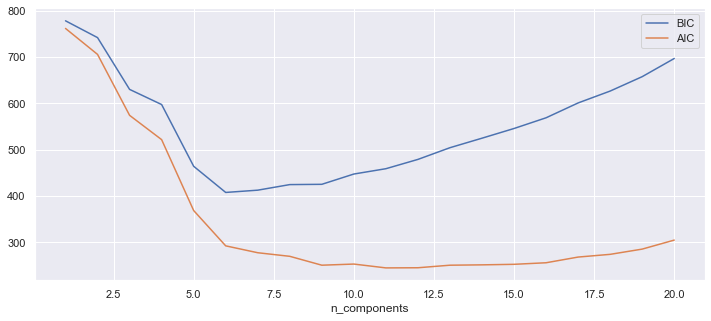

In [18]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]
plt.figure(figsize=(12, 5))
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

### <font color='green'> 최적의 클러스터 개 수는 AIC 또는 BIC를 최소화하는 값
- AIC는 16 개를 선택했을 때 너무 많은 반면 약 8-12 개 적당(BIC는 더 간단한 모델을 권장)
   *  <font color='red'> (주의사항) AIC/BIC는 GMM이 *클러스터링 알고리즘*으로 얼마나 잘 작동하는지가 아니라 *밀도 추정기*로서 얼마나 잘 작동하는지 측정
    
    
- GMM을 주로 밀도 추정기로 간주하고 간단한 데이터를 대상으로 클러스터링에 사용하는 것을 권장

## 4. Example: GMM for Generating New Data

We just saw a simple example of using GMM as a generative model of data in order to create new samples from the distribution defined by the input data.
Here we will run with this idea and generate *new handwritten digits* from the standard digits corpus that we have used before.

To start with, let's load the digits data using Scikit-Learn's data tools:

In [24]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Next let's plot the first 100 of these to recall exactly what we're looking at:

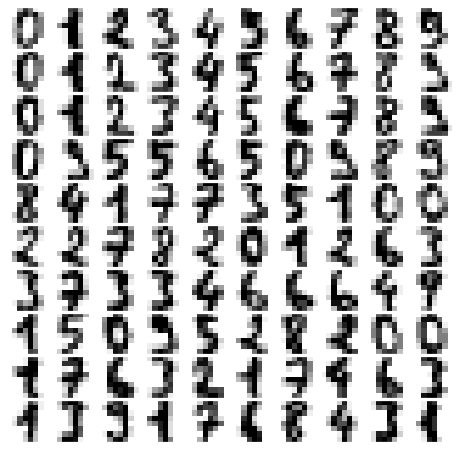

In [25]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
        
plot_digits(digits.data)

We have nearly 1,800 digits in 64 dimensions, and we can build a GMM on top of these to generate more.
GMMs can have difficulty converging in such a high dimensional space, so we will start with an invertible dimensionality reduction algorithm on the data.
Here we will use a straightforward PCA, asking it to preserve 99% of the variance in the projected data:

In [26]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

The result is 41 dimensions, a reduction of nearly 1/3 with almost no information loss.
Given this projected data, let's use the AIC to get a gauge for the number of GMM components we should use:

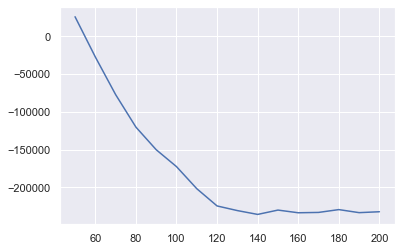

In [27]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

It appears that around 110 components minimizes the AIC; we will use this model.
Let's quickly fit this to the data and confirm that it has converged:

In [28]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Now we can draw samples of 100 new points within this 41-dimensional projected space, using the GMM as a generative model:

In [29]:
data_new = gmm.sample(100)
np.asarray(data_new[0]) # 튜플안의 array만 취해서 

array([[-2.53750422e-01,  1.69672106e-03,  2.60113959e-01, ...,
        -8.66713102e-01,  9.84824582e-01, -2.02742714e-01],
       [ 2.02088046e-01, -1.03471943e+00, -1.56047491e+00, ...,
        -5.57401080e-01,  6.90448457e-02,  5.26854851e-01],
       [ 3.28146245e-01,  1.71464521e+00, -4.35777789e-01, ...,
         2.87190945e-01,  2.49642090e-01,  1.73030939e+00],
       ...,
       [ 3.41957366e-01, -9.70934710e-01, -1.03699192e+00, ...,
        -8.31136284e-01, -3.00794089e-01,  4.17802091e-01],
       [-5.16966892e-01, -8.70533746e-01,  9.73963193e-01, ...,
        -1.17409746e+00,  1.78181313e+00, -9.17533028e-01],
       [-8.17254639e-02, -4.51975981e-01,  5.72274767e-01, ...,
        -1.79341600e-03,  2.60630756e-01,  1.05518913e+00]])

Finally, we can use the inverse transform of the PCA object to construct the new digits:

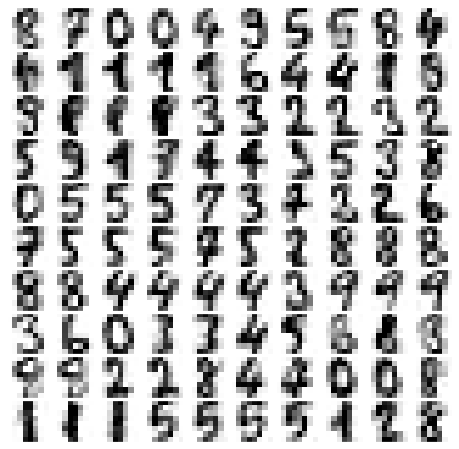

In [30]:
digits_new = pca.inverse_transform(np.asarray(data_new[0]))
plot_digits(digits_new)

The results for the most part look like plausible digits from the dataset!

Consider what we've done here: given a sampling of handwritten digits, we have modeled the distribution of that data in such a way that we can generate brand new samples of digits from the data: these are "handwritten digits" which do not individually appear in the original dataset, but rather capture the general features of the input data as modeled by the mixture model.

# End